In [1]:
import gym

import random
import numpy as np
from tqdm.notebook import tqdm

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.style.use('ggplot')

In [2]:
env = gym.make('Blackjack-v0', natural=True)

# Part I. Blackjack & strategy

## Dummy strategy

Let's consider a very simple strategy: say stand if we have a combination of 19, 20 or 21 points, and in all other cases say hit.<br> Use Monte Carlo methods to evaluate the benefits of this strategy.

In [3]:
class DummyAgent:
    def __init__(self):
        self._name = 'DummyAgent'
        
    @property
    def name(self):
        return self._name
    
    @staticmethod
    def get_action(state):
        if state[0] >= 19 and state[0] <= 21:
            return 0
        else:
            return 1

In [4]:
def run_experiment(env, agent):
    episode = list()
    state = env.reset()
    done = False
    
    while not done:
        action = agent.get_action(state)

        new_state, reward, done, _ = env.step(action=action)
        
        episode.append((state, action, reward))
        
        state = new_state
    return episode

In [5]:
def evaluate_policy(generate_episode, env, agent, episodes=5000):
    total_amount = list()
    for _ in tqdm(range(episodes)):
        episode = run_experiment(env, agent)
        
        total_amount.append(episode[-1][2])
    return total_amount

In [6]:
def mc_prediction(env, num_episodes, generate_episode, agent):
    evaluations = evaluate_policy(generate_episode, env, agent, episodes=num_episodes)
    return evaluations

In [7]:
agent = DummyAgent()
evaluations = mc_prediction(env, 100000, run_experiment, agent)

Average % of reward with DummyAgent is -> -18.6%


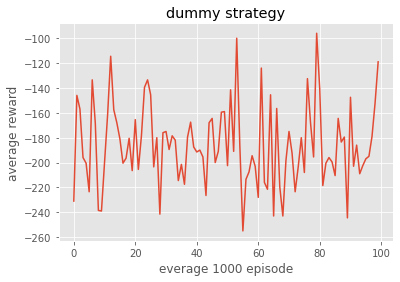

In [8]:
results = []
for i in range(len(evaluations) // 1000):
    results.append(sum(evaluations[i * 1000 : (i + 1) * 1000]))
    
print(f"Average % of reward with {agent.name} is -> {sum(evaluations) / len(evaluations) * 100}%")

plt.plot(results)
plt.xlabel('everage 1000 episode')
plt.ylabel('average reward')
plt.title('dummy strategy');

## Q-learning

Implement a reinforcement learning method without a model (you can use Q-learning, but it is recommended to try other methods, such as Monte Carlo control) to learn a strategy in blackjack using The openai Gym's Blackjack-v0 environment.

In [9]:
class AgentQLearn:
    def __init__(self, env, epsilon=1.0, alpha=0.5, gamma=0.9):
        self._name = 'Q-Learning Agent'
        self.env = env
        self.action_size = env.action_space.n
        self.epsilon = epsilon
        self.alpha = alpha    
        self.gamma = gamma    
        self.state_size = env.observation_space[0].n * env.observation_space[1].n
        self.Q = np.zeros((self.state_size, self.action_size))
    
    @property
    def name(self):
        return self._name
    
    def _get_Q_index(self, state):
        # only for more clear readability of code
        return self.env.observation_space[1].n * state[0] + state[1]
    
    def update_Q(self, new_state, states, actions, rewards):
        # cummulative reward for whole episode
        step = 0
        for state, action, reward in zip(states, actions, rewards):
            total_reward = 0
            gamma_exp = 0
            for curr_step in range(step, len(states)):  # also tried to apdate on every step - result
                                                        # was pretty close, but this method looks more miningful
                total_reward += (self.gamma ** gamma_exp) * rewards[curr_step]
                gamma_exp += 1
        
            new_state_index = self._get_Q_index(new_state)
            state_index = self._get_Q_index(state)

            cur_Q = self.Q[state_index][action]
            self.Q[state_index][action] = cur_Q + self.alpha * (total_reward - cur_Q)
            
            step += 1
        
    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(2)
        else:
            index = self._get_Q_index(state)
            return np.argmax(self.Q[index])

In [10]:
def run_experiment(env, agent, train=True):
    episode = list()
    state = env.reset()
    done = False
    
    # splitted on 3 lists only for more clarity and readability
    states, actions, rewards = list(), list(), list()
    
    while not done:
        action = agent.get_action(state)
        actions.append(action)
        
        new_state, reward, done, _ = env.step(action=action)
        
        episode.append((state, action, reward))
        
        state = new_state
        states.append(state)
        rewards.append(reward)
    
    # update only after episode is finished (if update after every step the result is pretty close)
    if train:
        agent.update_Q(new_state, states, actions, rewards)
        
    return episode

In [11]:
def evaluate_policy(generate_episode, env, agent,
                    episodes=5000,
                    validate_every=25000,
                    num_of_validated_episodes=100000):
    total_amount = list()
    for i in tqdm(range(1, episodes + 1)):
        if i % validate_every == 0:
            validate_amount = list()
            for _ in range(num_of_validated_episodes):
                validate_episode = run_experiment(env, agent, train=False)
                validate_amount.append(validate_episode[-1][2])
            print(f"On {i} validated amount is -> ",
                  f"{sum(validate_amount) / len(validate_amount)} evaluated on 100k samples")
        episode = run_experiment(env, agent)
        total_amount.append(episode[-1][2])
    return total_amount

In [12]:
gamma = 0.85
epsilon = 0.025
alpha = 0.01
agent = AgentQLearn(env, epsilon=epsilon, alpha=alpha, gamma=gamma)
evaluations = mc_prediction(env, 300000, run_experiment, agent)

On 25000 validated amount is ->  -0.071735 evaluated on 100k samples
On 50000 validated amount is ->  -0.065995 evaluated on 100k samples
On 75000 validated amount is ->  -0.07429 evaluated on 100k samples
On 100000 validated amount is ->  -0.07422 evaluated on 100k samples
On 125000 validated amount is ->  -0.067285 evaluated on 100k samples
On 150000 validated amount is ->  -0.06728 evaluated on 100k samples
On 175000 validated amount is ->  -0.080105 evaluated on 100k samples
On 200000 validated amount is ->  -0.073585 evaluated on 100k samples
On 225000 validated amount is ->  -0.060855 evaluated on 100k samples
On 250000 validated amount is ->  -0.067215 evaluated on 100k samples
On 275000 validated amount is ->  -0.08063 evaluated on 100k samples
On 300000 validated amount is ->  -0.084165 evaluated on 100k samples



Average % of reward with Q-Learning Agent is -> -7.532333333333334%


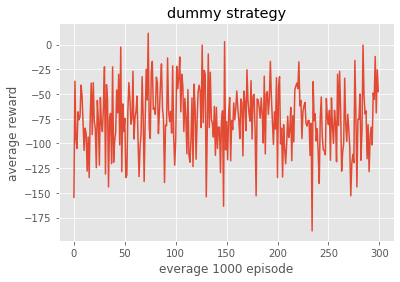

In [13]:
results = []
for i in range(len(evaluations) // 1000):
    results.append(sum(evaluations[i * 1000 : (i + 1) * 1000]))

print(f"Average % of reward with {agent.name} is -> {sum(evaluations) / len(evaluations) * 100}%")

plt.plot(results)
plt.xlabel('everage 1000 episode')
plt.ylabel('average reward')
plt.title('dummy strategy');

# Part 2 - Doubling

## Redefine new enviroment

In [14]:
# function used in gym framework
from gym import spaces
from gym.utils import seeding
from gym.envs.toy_text.blackjack import (draw_card, draw_hand, is_bust, score,
                                         is_natural, usable_ace, sum_hand, cmp)

In [15]:
class BlackjackEnvWithDouble(gym.Env):
    def __init__(self, natural=False, double_down=False):
        if double_down:
            self.action_space = spaces.Discrete(3)
        else:
             self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        
        self.seed()
        
        self.natural = natural
        self.double_down = double_down

        self.reset()
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def step(self, action):
        if self.natural and is_natural(self.player):  # natural Blackjack
            if is_natural(self.dealer):
                reward = 0.0  # player and dealer has
            else:
                reward = 1.5  # player has
            done = True
            return self._get_obs(), reward, done, {}
        assert self.action_space.contains(action)

        if action == 2: # double down: bet double and get only 1 card, then compare
            self.player.append(draw_card(self.np_random))
            done = True
            if is_bust(self.player):
                reward = -2.0
            else: 
                while sum_hand(self.dealer) < 17:
                    self.dealer.append(draw_card(self.np_random))
                reward = 2 * cmp(score(self.player), score(self.dealer))
        elif action == 1:  # hit: add a card to players hand and return
            reward = 2 * cmp(score(self.player), score(self.dealer))
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.0
            else:
                done = False
                reward = 0.0
        elif action == 0:  # stick: play out the dealer's hand, then compare
            done = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
        return self._get_obs(), reward, done, {}
                
    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))
    
    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

In [17]:
double_env = BlackjackEnvWithDouble(natural=True)
gamma = 0.9
epsilon = 0.025
alpha = 0.01
agent = AgentQLearn(double_env, epsilon=epsilon, alpha=alpha, gamma=gamma)
evaluations = mc_prediction(double_env, 300000, run_experiment, agent)

On 25000 validated amount is ->  -0.0885 evaluated on 100k samples
On 50000 validated amount is ->  -0.083955 evaluated on 100k samples
On 75000 validated amount is ->  -0.069065 evaluated on 100k samples
On 100000 validated amount is ->  -0.061945 evaluated on 100k samples
On 125000 validated amount is ->  -0.086235 evaluated on 100k samples
On 150000 validated amount is ->  -0.061635 evaluated on 100k samples
On 175000 validated amount is ->  -0.055895 evaluated on 100k samples
On 200000 validated amount is ->  -0.0596 evaluated on 100k samples
On 225000 validated amount is ->  -0.053975 evaluated on 100k samples
On 250000 validated amount is ->  -0.07683 evaluated on 100k samples
On 275000 validated amount is ->  -0.062235 evaluated on 100k samples
On 300000 validated amount is ->  -0.054675 evaluated on 100k samples



Average % of reward with Q-Learning Agent is -> -7.098166666666667%


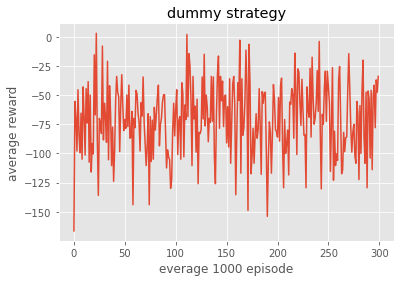

In [18]:
results = []
for i in range(len(evaluations) // 1000):
    results.append(sum(evaluations[i * 1000 : (i + 1) * 1000]))

print(f"Average % of reward with {agent.name} is -> {sum(evaluations) / len(evaluations) * 100}%")

plt.plot(results)
plt.xlabel('everage 1000 episode')
plt.ylabel('average reward')
plt.title('dummy strategy');